In [1]:
%matplotlib inline
%load_ext sql

In [2]:
from concurrent.futures import ProcessPoolExecutor
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style("whitegrid")
sns.set_context("notebook")

In [4]:
posts = pd.read_hdf("metadata.h5", "posts")
tag_count = pd.read_hdf("metadata.h5", "tag_count")

## Manually remove some tags that are not obvious from the images

Or that do not matter for our learning goals.

In [5]:
useless_tags = [
    "highres",
    "bad_id",
    "bad_pixiv_id",
    "monochrome",
    "censored",
    "alternate_costume",
    "hetero",
    "sketch",
    "yuri",
    "character_name",
    "greyscale",
    "artist_name",
    "artist_request",
    "artist_request",
    "copyright_request",
    "absurdres",
    "dated",
    "signature",
    "cosplay",
    "translated",
    "copyright_name",
    "traditional_media",
    "twitter_username",
    "alternate_hairstyle",
    "mosaic_censoring",
    "parody",
    "english",
    "gradient",
    "couple",
    "sisters",
    "cover_page",
    "crossover",
    "uncensored",
    "official_art",
    "letterboxed",
    "translation_request",
    "scan",
    "game_cg",
    "remodel_(kantai_collection)",
    "depth_of_field",
    "convenient_censoring",
    "foreshortening",
    "watermark",
    "genderswap",
    "adapted_costume",
    "pov",
    "wallpaper",
    "pokemon_(creature)",
    "text",
    "kemonomimi_mode",
    "shinkaisei-kan",
    "genderswap_(mtf)",
    "personification",
    "blurry",
    "wind",
    "younger",
    "cover",
    # Tags for the background
    "white_background",
    "grey_background",
    "gradient_background",
    "blue_background",
    "pink_background",
    # And this is about the "camera" position
    "cowboy shot",
    "dutch_angle",
    "full_body",
    "upper_body"
]

In [6]:
# The strange indices here are necessary because I want the 'kiss' tag that wouldn't be included otherwise.
tag_count_filtered = tag_count[tag_count.name.isin(useless_tags) == False].iloc[np.append(np.arange(508), 514)]
tag_count_filtered.index = pd.RangeIndex(1, len(tag_count_filtered) + 1)
# Also add the three ratings to the tags!

In [7]:
print(tag_count_filtered.to_string())

           id                           name    count
1           4                          1girl  1375743
2          36                           solo  1180211
3          18                      long_hair   880096
4         210                        breasts   589596
5           8                          blush   556491
6          59                          smile   544873
7         184                     short_hair   530580
8          20              looking_at_viewer   439081
9         412                     open_mouth   422754
10         69                      blue_eyes   407666
11         94                    blonde_hair   399524
12         10                     brown_hair   369444
13        180                 multiple_girls   362782
14         35                          skirt   350711
15        134                     thighhighs   322695
16         28                       red_eyes   312355
17         93                     black_hair   307234
18        100               

## And now let's build the training targets

Using some simple SQL queries.

In [8]:
def get_dbconnect_string(json_path, db_interface="postgresql+psycopg2"):
    with open(json_path, "rb") as fd:
        configuration = json.loads(fd.read())
    return db_interface + "://{user}:{password}@{host}:{port}/{database}".format(**configuration)
db_configuration = get_dbconnect_string("database.json")

In [9]:
%%sql $db_configuration
        SELECT MIN(id), MAX(id), COUNT(*) FROM posts

1 rows affected.


min,max,count
1,2900000,2867507


In [10]:
post_id_list = posts.id.tolist()
tag_id_list = tag_count_filtered.id.tolist()

In [11]:
# This took a very long time
tagged = %sql SELECT * FROM tagged WHERE tag_id = ANY(:tag_id_list) AND post_id = ANY(:post_id_list) 

30283382 rows affected.


In [12]:
# And this took also quite long because my memory was full
tagged = np.fromiter(map(tuple, tagged), dtype=[("tag_id", np.int32), ("post_id", np.int32)], count=len(tagged))

In [13]:
tagged_series = pd.Series(tagged["tag_id"], index=tagged["post_id"])
tagged_series.sort_index(inplace=True)

In [14]:
tagged_series.to_hdf("metadata.h5", "tagged", mode="a", complevel=9, complib="bzip2")

## Now we need targets with fixed dimension

Having the data is nice and all but we need it in the right format.

In [15]:
tagged = pd.read_hdf("metadata.h5", "tagged")

In [16]:
tagged_count = tagged.groupby(level=0).count()
tagged_descr = tagged_count.describe()
print(tagged_descr.to_string())

count    1.862636e+06
mean     1.625835e+01
std      7.955755e+00
min      1.000000e+00
25%      1.100000e+01
50%      1.500000e+01
75%      2.000000e+01
max      2.080000e+02


Text(0.5,1,'Distribution of relevant tags per image')

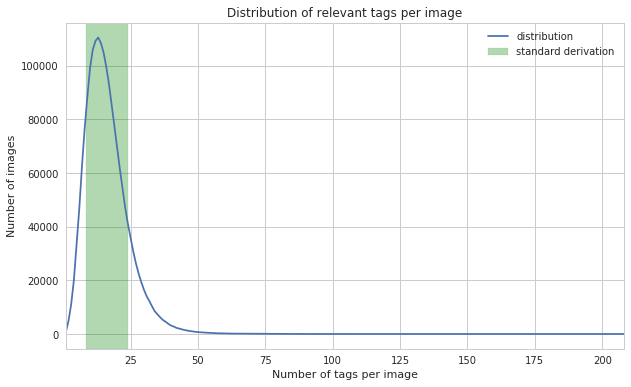

In [17]:
tagged_count.groupby(by=tagged_count).count().plot()
plt.xlim(tagged_descr.loc["min"], tagged_descr.loc["max"])
plt.axvspan(tagged_descr.loc["mean"] - tagged_descr.loc["std"], tagged_descr.loc["mean"] + tagged_descr.loc["std"], color="green", alpha=0.3)
plt.legend(["distribution", "standard derivation"])
plt.xlabel("Number of tags per image")
plt.ylabel("Number of images")
plt.title("Distribution of relevant tags per image")

This is a really interesting plot since the tag count distribution is obviously normal distributed and thus one could integrate over the plot to e.g. remove outliers. However, I don't deem this necessary here.

In [18]:
# This is for creating the target matrix
nr_posts = int(tagged_descr.loc["count"])
nr_tags = len(tag_count_filtered)
target = np.zeros((nr_posts, nr_tags), dtype=np.bool)
tag_ids = tag_count_filtered.sort_values("name").id.values
for i, post_id in enumerate(tagged_count.index):
    target[i] = np.isin(tag_ids, tagged.loc[post_id])

In [19]:
assert target.sum() == tagged.isin(tag_count_filtered.id).sum()

In [20]:
index = pd.MultiIndex.from_arrays(tag_count_filtered.sort_values("name").iloc[:,0:2].T.values,
                                  names=("id", "name"))
target_frame = pd.DataFrame(target, index=tagged_count.index, columns=index)

In [21]:
assert (target_frame.dtypes == np.bool).all()
assert target_frame.sum().sum() == tagged.isin(tag_count_filtered.id).sum()

In [22]:
target_frame.to_hdf("metadata.h5", "target", mode="a", complevel=9, complib="bzip2")